In [1]:
%load_ext autoreload
%autoreload 2

In [46]:
import pandas as pd
import numpy as np
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from sklearn.utils import class_weight
from sklearn.linear_model import LogisticRegression
from collections import defaultdict
import matplotlib.pyplot as plt
import pickle

from src.embeddings import get_embedding_dictionnary, get_embeddings_and_word_index, sequences_to_index
from src.dataset import load_dataset, load_datasets_and_vocab_pipeline, train_test_val_split
from src.evaluate import get_metrics, get_predictions, compare_metrics, get_metrics_binary
from src.models import model_mine, model_conv1d, EnsembleModel
from src.submission import generate_predictions
from src.model_saverloader import *
from src.utils import get_wrongs, emotion2label, label2emotion, reindex_sequences

embeddings_path = './data/embeddings/datastories.twitter.300d.txt'

In [14]:
os.makedirs('pickles/models/', exist_ok=True)

### Load and preprocess Train and Test

In [4]:
(X_train_txt, y_train), (X_test_txt, y_test), (vocab, max_seq_len) = load_datasets_and_vocab_pipeline()

Reading twitter - 1grams ...
Reading twitter - 2grams ...


Preprocessing...:   0%|          | 0/30160 [00:00<?, ?it/s]

Reading twitter - 1grams ...


Building vocabulary...: 100%|██████████| 32915/32915 [00:00<00:00, 184701.51it/s]


In [5]:
X_train_txt.shape, y_train.values.shape, X_test_txt.shape, y_test.values.shape

((30160,), (30160,), (2755,), (2755,))

### Check sequences lengths

In [6]:
lenghts = []
lenghts += [len(x) for x in X_train_txt]
lenghts += [len(x) for x in X_test_txt]

len(lenghts)

32915

32915 32909 32806


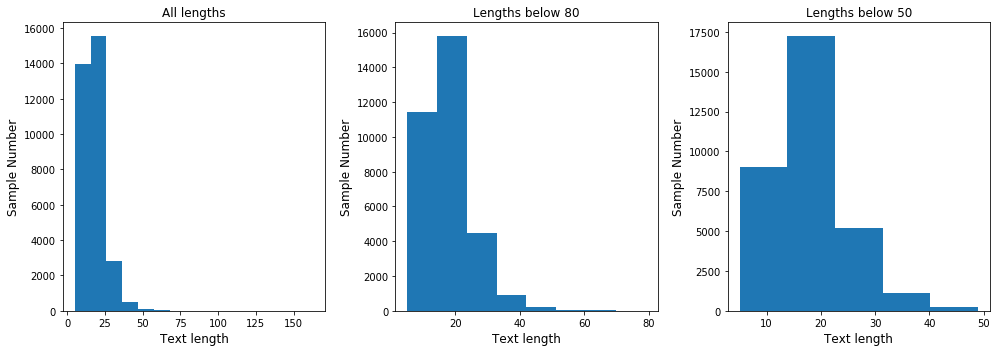

In [7]:
len2 = [l for l in lenghts if l < 80]
len3 = [l for l in lenghts if l < 50]

print(len(lenghts), len(len2), len(len3))

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(14,5))

ax1.hist(lenghts, bins=15)
ax1.set_xlabel('Text length', fontsize=12)
ax1.set_ylabel('Sample Number', fontsize=12)
ax1.set_title('All lengths')

ax2.hist(len2, bins=8)
ax2.set_xlabel('Text length', fontsize=12)
ax2.set_ylabel('Sample Number', fontsize=12)
ax2.set_title('Lengths below 80')

ax3.hist(len3, bins=5)
ax3.set_xlabel('Text length', fontsize=12)
ax3.set_ylabel('Sample Number', fontsize=12)
ax3.set_title('Lengths below 50')

plt.tight_layout()

### Compute the classes weights because our dataset is largely unbalanced

In [8]:
cls_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
cls_weights

array([1.36941518, 1.77704454, 1.38019403, 0.50441531])

### Create an embedding matrix for our vocabulary

In [9]:
max_seq_len = 80
emb_matrix, word_index, unknown_words = get_embeddings_and_word_index(embeddings_path, max_seq_len, vocab)
max_seq_len = word_index['<max_seq_len>']
# Unknown words: 1300

print(f'Unknown words from the vocabulary: {len(unknown_words)} (previously 1300 without spellcheck fixes)')
print(f'{len(unknown_words) / len(vocab) * 100:.2f}% of our vocabulary are unknown words to the embedding matrix')

Unknown words from the vocabulary: 513 (previously 1300 without spellcheck fixes)
3.48% of our vocabulary are unknown words to the embedding matrix


### Transforming our sequences of words to indexes

In [10]:
X_train = sequences_to_index(X_train_txt, word_index)
X_test = sequences_to_index(X_test_txt, word_index)

X_train.shape, X_test.shape

((30160, 80), (2755, 80))

In [11]:
y_train = to_categorical(y_train, 4) if len(y_train.shape) == 1 else y_train
y_test = to_categorical(y_test, 4) if len(y_test.shape) == 1 else y_test
(x_trn, y_trn), (x_val, y_val) = train_test_val_split(X_train, y_train)


print('training set: ' + str(len(x_trn)) + ' samples')
print('validation set: ' + str(len(x_val)) + ' samples')

print('x_train:', x_trn.shape)
print('y_train:', y_trn.shape)

binarize = np.vectorize(lambda x: 0 if x in [0, 1, 2] else 1)
y_trn_2 = to_categorical(binarize(y_trn.argmax(axis=1)), 2)
y_val_2 = to_categorical(binarize(y_val.argmax(axis=1)), 2)

training set: 21111 samples
validation set: 9049 samples
x_train: (21111, 80)
y_train: (21111, 4)


## Training categorical

In [12]:
model = model_mine(emb_matrix, max_seq_len)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 80, 300)           4424100   
_________________________________________________________________
dropout_1 (Dropout)          (None, 80, 300)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 80, 300)           541200    
_________________________________________________________________
dropout_2 (Dropout)          (None, 80, 300)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 80, 300)           541200    
_________________________________________________________________
dropout_3 (Dropout)          (None, 80, 300)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 24000)             0         
__________

In [15]:
callbacks_list = [
        ModelCheckpoint(filepath='pickles/models/best.h5', save_best_only=True, verbose=1),
        EarlyStopping(patience=4, verbose=0)
    ]

In [16]:
history = model.fit(x_trn, y_trn, batch_size=128, validation_data=(x_val, y_val), epochs=15, class_weight=cls_weights, callbacks=callbacks_list)

Train on 21111 samples, validate on 9049 samples
Epoch 1/15
21111/21111 [==============================] - 206s 10ms/step - loss: 0.8371 - acc: 0.6677 - val_loss: 0.6303 - val_acc: 0.7499

Epoch 00001: val_loss improved from inf to 0.63030, saving model to pickles/models/best.h5
Epoch 2/15
21111/21111 [==============================] - 204s 10ms/step - loss: 0.5657 - acc: 0.7876 - val_loss: 0.4711 - val_acc: 0.8273

Epoch 00002: val_loss improved from 0.63030 to 0.47108, saving model to pickles/models/best.h5
Epoch 3/15
21111/21111 [==============================] - 205s 10ms/step - loss: 0.4751 - acc: 0.8234 - val_loss: 0.4241 - val_acc: 0.8472

Epoch 00003: val_loss improved from 0.47108 to 0.42411, saving model to pickles/models/best.h5
Epoch 4/15
21111/21111 [==============================] - 193s 9ms/step - loss: 0.4257 - acc: 0.8422 - val_loss: 0.3802 - val_acc: 0.8600

Epoch 00004: val_loss improved from 0.42411 to 0.38018, saving model to pickles/models/best.h5
Epoch 5/15
21111

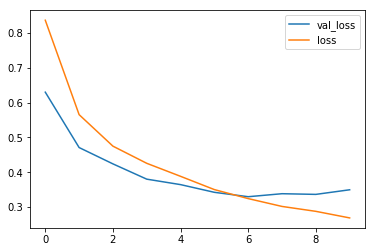

In [18]:
histories = [history]
eps, val_loss, loss = [], [], []
for h in histories:
    eps += h.epoch
    val_loss += h.history['val_loss']
    loss += h.history['loss']

plt.plot(eps, val_loss, label='val_loss')
plt.plot(eps, loss, label='loss')

plt.legend()

### Evaluating our categorical model

In [19]:
model = load_model('pickles/models/best.h5')

In [20]:
best_metrics = load_best_metrics(mode='categorical')

Best categorical model is acc_0.9060-f1_0.7061 with f1=0.7061355939404048


In [21]:
y_pred_test, proba_preds = get_predictions(model, X_test)

True Positives per class :  [ 130.  113.  100. 2097.]
False Positives per class :  [ 92. 109.  55.  59.]
False Negatives per class :  [ 20.  29.  25. 241.]

Class angry : Precision : 0.586, Recall : 0.867, F1 : 0.699
Class happy : Precision : 0.509, Recall : 0.796, F1 : 0.621
Class sad : Precision : 0.645, Recall : 0.800, F1 : 0.714

Ignoring the Others class, Macro Precision : 0.5799, Macro Recall : 0.8208, Macro F1 : 0.6797
Ignoring the Others class, Micro TP : 343, FP : 256, FN : 74



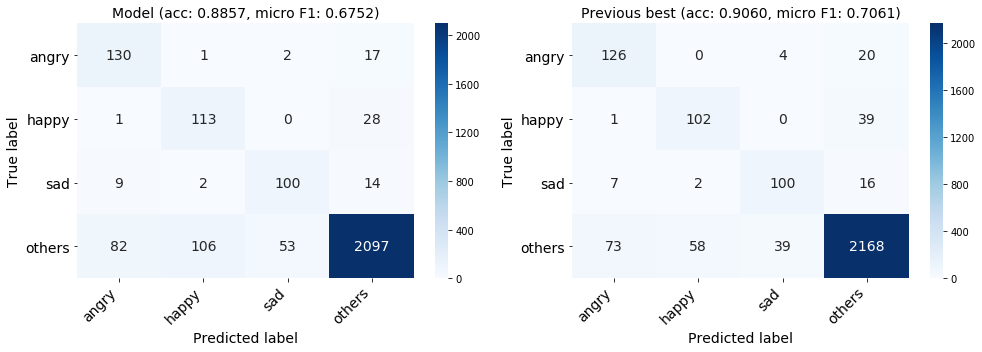

In [22]:
model_metrics = compare_metrics(proba_preds, y_test, best_metrics, mode='categorical')

In [23]:
save_model_full(model, emb_matrix, word_index, model_metrics)

Model saved at pickles/models/categorical/acc_0.8857-f1_0.6752/


## Training Others vs all (binary)

In [24]:
model_bin = model_conv1d(emb_matrix, max_seq_len, class_number=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 80, 300)           4424100   
_________________________________________________________________
dropout_4 (Dropout)          (None, 80, 300)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 80, 64)            96064     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 16, 64)            0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 64)            0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 16, 300)           258000    
_________________________________________________________________
dropout_6 (Dropout)          (None, 16, 300)           0         
__________

In [25]:
callbacks_list_bin = [
        ModelCheckpoint(filepath='pickles/models/best_bin.h5', save_best_only=True, verbose=1),
        EarlyStopping(patience=4, verbose=0)
    ]

In [26]:
cls_weight_bin = np.array([0.5, 1.5])
cls_weight_bin

array([0.5, 1.5])

In [27]:
history_bin = model_bin.fit(x_trn, y_trn_2, batch_size=128, validation_data=(x_val, y_val_2), epochs=20, class_weight=cls_weight_bin, callbacks=callbacks_list_bin)

Train on 21111 samples, validate on 9049 samples
Epoch 1/20
21111/21111 [==============================] - 56s 3ms/step - loss: 0.5596 - acc: 0.7023 - val_loss: 0.4450 - val_acc: 0.8074

Epoch 00001: val_loss improved from inf to 0.44501, saving model to pickles/models/best_bin.h5
Epoch 2/20
21111/21111 [==============================] - 47s 2ms/step - loss: 0.4506 - acc: 0.7922 - val_loss: 0.4108 - val_acc: 0.8183

Epoch 00002: val_loss improved from 0.44501 to 0.41081, saving model to pickles/models/best_bin.h5
Epoch 3/20
21111/21111 [==============================] - 47s 2ms/step - loss: 0.4130 - acc: 0.8147 - val_loss: 0.3905 - val_acc: 0.8173

Epoch 00003: val_loss improved from 0.41081 to 0.39050, saving model to pickles/models/best_bin.h5
Epoch 4/20
21111/21111 [==============================] - 49s 2ms/step - loss: 0.3835 - acc: 0.8331 - val_loss: 0.3324 - val_acc: 0.8559

Epoch 00004: val_loss improved from 0.39050 to 0.33245, saving model to pickles/models/best_bin.h5
Epoch 5

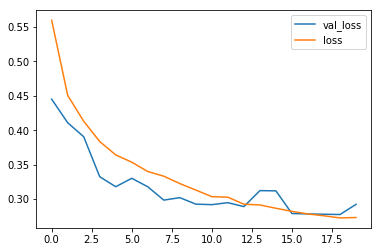

In [28]:
histories = [history_bin]
eps, val_loss, loss = [], [], []
for h in histories:
    eps += h.epoch
    val_loss += h.history['val_loss']
    loss += h.history['loss']

plt.plot(eps, val_loss, label='val_loss')
plt.plot(eps, loss, label='loss')

plt.legend()

### Evaluate our binary model

In [29]:
model_bin = load_model('pickles/models/best_bin.h5')

In [30]:
best_bin_metrics = load_best_metrics(mode='binary')

Best binary model is acc_0.8915-f1_0.9348 with f1=0.9347588915557495


In [31]:
preds_2_tst = model_bin.predict(X_test, batch_size=128)

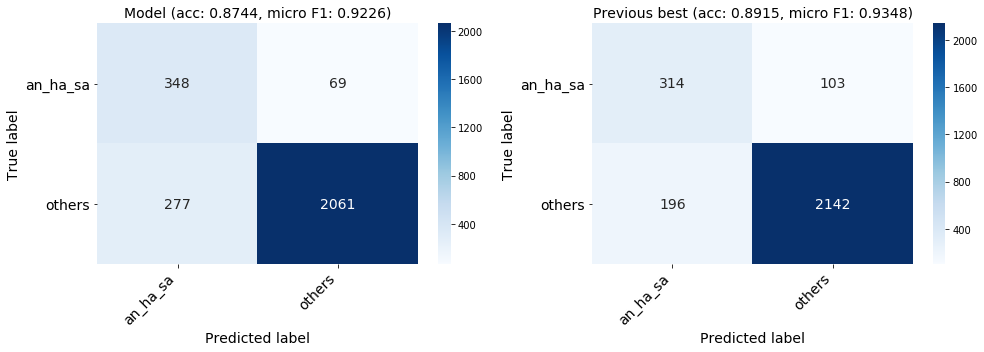

In [32]:
model_bin_metrics = compare_metrics(preds_2_tst, y_test, best_bin_metrics, mode='binary')

In [33]:
save_model_full(model_bin, emb_matrix, word_index, model_bin_metrics)

Model saved at pickles/models/binary/acc_0.8744-f1_0.9226/


## Ensemble binary and categorical

In [34]:
model_cat, _, word_index_cat, model_metrics_cat = load_best_model(mode='categorical')

Best categorical model is acc_0.9060-f1_0.7061 with f1=0.7061355939404048
Loaded model from pickles/models/categorical/acc_0.9060-f1_0.7061/


In [35]:
model_bin, _, word_index_bin, model_metrics_bin = load_best_model(mode='binary')

Best binary model is acc_0.8915-f1_0.9348 with f1=0.9347588915557495
Loaded model from pickles/models/binary/acc_0.8915-f1_0.9348/


In [36]:
model_ens = EnsembleModel(*load_best_model(mode='ensemble'))

Best ensemble model is acc_0.9056-f1_0.7099 with f1=0.7098830899953152
Loaded model from pickles/models/ensemble/acc_0.9056-f1_0.7099/


In [37]:
model_1 = model_cat
model_2 = model_bin

#### Test combi

In [38]:
preds_tst_1 = model_metrics_cat['y_proba']
preds_tst_2 = model_bin_metrics['y_proba']

print(f'categorical f1(bin)={get_metrics_binary(preds_tst_1, y_test)[1]}')
print(f'binary f1(bin)={get_metrics_binary(preds_tst_2, y_test)[1]}')

combi_preds_tst = np.hstack([preds_tst_1, preds_tst_2])
combi_preds_tst.shape

categorical f1(bin)=0.946518227461253
binary f1(bin)=0.9225604297224709


(2755, 6)

#### Train combi

In [47]:
reindex_sequences(X_train, word_index, word_index_cat)

In [48]:
trn_preds_1 = model_1.predict(X_train, batch_size=128)

In [49]:
reindex_sequences(X_train, word_index_cat, word_index_bin)

In [50]:
trn_preds_2 = model_2.predict(X_train, batch_size=128)

In [51]:
combi_preds_trn = np.hstack([trn_preds_1, trn_preds_2])
combi_preds_trn.shape

(30160, 6)

In [52]:
lreg = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=1000).fit(combi_preds_trn, y_train.argmax(axis=1))

### Evaluate our ensembling model

In [53]:
lreg_pred_tst = lreg.predict_proba(combi_preds_tst)

In [54]:
best_metrics_combi = load_best_metrics(mode='ensemble')

Best ensemble model is acc_0.9056-f1_0.7099 with f1=0.7098830899953152


True Positives per class :  [ 129.  108.  102. 2133.]
False Positives per class :  [89. 80. 51. 63.]
False Negatives per class :  [ 21.  34.  23. 205.]

Class angry : Precision : 0.592, Recall : 0.860, F1 : 0.701
Class happy : Precision : 0.574, Recall : 0.761, F1 : 0.655
Class sad : Precision : 0.667, Recall : 0.816, F1 : 0.734

Ignoring the Others class, Macro Precision : 0.6110, Macro Recall : 0.8122, Macro F1 : 0.6973
Ignoring the Others class, Micro TP : 339, FP : 220, FN : 78



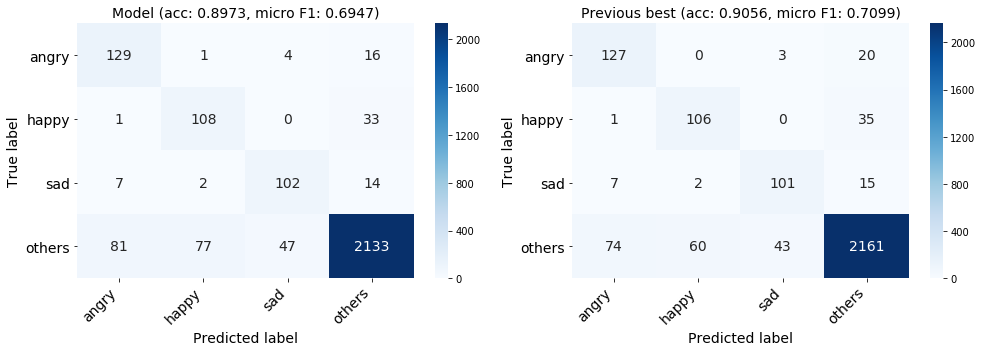

In [55]:
model_combi_metrics = compare_metrics(lreg_pred_tst, y_test, best_metrics_combi, mode='ensemble')

In [193]:
save_ensemble_model(lreg, model_combi_metrics, [model_metrics_cat, model_metrics_bin])

Model saved at pickles/models/ensemble/acc_0.9049-f1_0.7087/


## Generating a submission file

In [56]:
# model, emb_matrix, word_index, model_metrics = load_best_model(mode='categorical')
model = EnsembleModel(*load_best_model(mode='ensemble'))

Best ensemble model is acc_0.9056-f1_0.7099 with f1=0.7098830899953152
Loaded model from pickles/models/ensemble/acc_0.9056-f1_0.7099/


In [58]:
y_pred_sub, proba_preds = generate_predictions(model, 'data/test.txt', word_index=word_index)

Loading dataset...
Reading twitter - 1grams ...
Reading twitter - 2grams ...


Preprocessing...:   0%|          | 0/2755 [00:00<?, ?it/s]

Reading twitter - 1grams ...


Preprocessing...: 100%|██████████| 2755/2755 [00:01<00:00, 2327.59it/s]


Generating Predictions...
Loaded model from pickles/models/categorical/acc_0.9060-f1_0.7061/
Loaded model from pickles/models/binary/acc_0.8846-f1_0.9293/
Done. Wrote submission.txt file at project's root


### Explore answers

In [59]:
wrong_df = get_wrongs(lreg_pred_tst, y_test, X_test_txt, 'happy')
wrong_df.head()

,Predicted,Actual,Text
21,happy,sad,but . <repeated> <eos> then <eos> i am feeling...
159,happy,others,missed you to <elongated> <eos> lol how are yo...
213,happy,others,welcome dear <eos> you are always welcome dear...
227,happy,others,i am funny <eos> <allcaps> youre hilarious </a...
290,happy,others,okay i am going office right now my sweet hear...
